# **Fake-News-Classification**
**Problem Statement:**

We consume news through several mediums throughout the day in our daily routine, but sometimes it becomes difficult to decide which one is fake and which one is authentic. Our job is to create a model which predicts whether a given news is real or fake.

In [3]:
pip install --upgrade scikit-learn

In [4]:
import sklearn
print(sklearn.__version__)

1.3.2


In [5]:
#Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **1. Data Gathering**

In [6]:
#load the dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/News_dataset.csv")

In [7]:
print(df.shape)
df.head()

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1




```
There is no need of id, author columns because ID coulmn is randomly created one. Here we are focusing only title,text columns only.
```



In [8]:
df.drop(["author","id"],axis=1,inplace = True)

In [9]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [10]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai



```
The text values have more no of sentence from each rows. so it will take more
time for data preprocessing and model building, so we currently focused with
title column only.
```



In [11]:
df.drop("text",axis=1,inplace=True)

In [12]:
#check and remove the duplicates
df.duplicated().sum()

996

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()

0

In [15]:
df.dtypes

title    object
label     int64
dtype: object

In [16]:
#to handle the miising values
df.isnull().sum()

title    1
label    0
dtype: int64

In [17]:
df.dropna(inplace=True)

In [18]:
df.isnull().sum()

title    0
label    0
dtype: int64

In [19]:
#statistical information
df.describe()

,label
count,19803.000000
mean,0.475786
std,0.499426
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000




```
label is actually categorical value hence the 25%-50%-75% distribution is not propoer
```



In [20]:
df.reset_index(inplace=True,drop=True)
df.head()

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [47]:
len(df)

19803

## **1.2 EDA-Exploratory Data Analysis**

### **Univariate Analysis**

In [21]:
df.columns

Index(['title', 'label'], dtype='object')

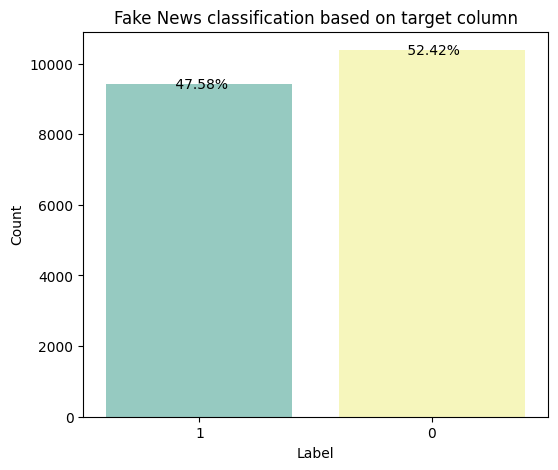

In [22]:
#distribution of feature plot
color_palette = sns.color_palette("Set3",n_colors=2)
plt.figure(figsize=(6,5))
ax=plt.subplot(1,1,1)
order=df['label'].value_counts().index[::-1]
sns.countplot(data=df,x='label',order=order,palette=color_palette)
plt.xticks(rotation=0)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Fake News classification based on target column")
total=len(df)
for p in ax.patches:
 height = p.get_height()
 percentage = (height/total)*100
 ax.annotate(f'{percentage : .2f}%',(p.get_x() + p.get_width() / 2,height),ha='center',va='center',color='black')
plt.show()



```
from the above result the data set is evenly distributed
```



## **1.3 Tokenization**

In [23]:
#word tokenize
sample_data = df['title'][0]
sample_data = sample_data.split()
sample_data

['House',
 'Dem',
 'Aide:',
 'We',
 'Didn’t',
 'Even',
 'See',
 'Comey’s',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It']

## **1.4 Make Lowercase**

In [24]:
sample_data = [data.lower() for data in sample_data]
sample_data

['house',
 'dem',
 'aide:',
 'we',
 'didn’t',
 'even',
 'see',
 'comey’s',
 'letter',
 'until',
 'jason',
 'chaffetz',
 'tweeted',
 'it']

## **1.5 Remove Stopwords**

In [25]:
stopwords = stopwords.words('english')
print(stopwords[:10])
print(len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
179


In [26]:
sample_data = [ data for data in sample_data if data not in stopwords ]
print(sample_data)
len(sample_data)

['house', 'dem', 'aide:', 'didn’t', 'even', 'see', 'comey’s', 'letter', 'jason', 'chaffetz', 'tweeted']


11

## **1.6 stemming**

In [27]:
ps = PorterStemmer()
sample_data_stemming = [ps.stem(data) for data in sample_data]
print(len(sample_data_stemming))
sample_data_stemming

11


['hous',
 'dem',
 'aide:',
 'didn’t',
 'even',
 'see',
 'comey’',
 'letter',
 'jason',
 'chaffetz',
 'tweet']

## **1.7 Lemmatization**

In [28]:
lm =WordNetLemmatizer()
sample_data_lemmatize = [lm.lemmatize(data) for data in sample_data]
print(len(sample_data_lemmatize))
sample_data_lemmatize

11


['house',
 'dem',
 'aide:',
 'didn’t',
 'even',
 'see',
 'comey’s',
 'letter',
 'jason',
 'chaffetz',
 'tweeted']

In [41]:
corpus = []
for i in range (len(df)):
    review = re.sub('^a-zA-Z0-9',' ', df['title'][i])
    review = review.lower()
    review = review.split()
    review = [lm.lemmatize(data) for data in review if data not in stopwords]
    review = " ".join(review)
    corpus.append(review)

In [46]:
len(corpus[0])

69

In [31]:
print(f"df['title'][0] : {df['title'][0]}")
print(f"corpus[0] : {corpus[0]}")

df['title'][0] : House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
corpus[0] : house dem aide: didn’t even see comey’s letter jason chaffetz tweeted


## **1.8 Vectorization (Convert Text data into the Vector)**

In [32]:
tf = TfidfVectorizer()
x = tf.fit_transform(corpus).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **1.9 Data splitting**

In [33]:
y = df['label']
y

0        1
1        0
2        1
3        1
4        1
        ..
19798    0
19799    0
19800    0
19801    0
19802    1
Name: label, Length: 19803, dtype: int64

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [44]:
len(x_train[0])

21244

### **1.10 Scaling**

In [32]:
from sklearn.preprocessing import StandardScaler #import StandardScaler funtion
scaler =StandardScaler() #Initialize StandardScaler funtion
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# **2.Model Building**

## **2.1Choosing the best depth value**

In [35]:
from sklearn.ensemble import RandomForestClassifier
for depth in [10,12,15,20,30,40,50]:
  rf = RandomForestClassifier(max_depth = depth)
  rf.fit(x_train_scaled, y_train)
  train_score = rf.score(x_train_scaled, y_train)
  cross_val_result = np.mean(cross_val_score(rf, x_train_scaled, y_train, cv = 10))
  print(f'Depth : {depth}, training score : {train_score} and cross-val score : {cross_val_result}')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.2  Implementing Random Forest Regression**

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 10)
rf.fit(x_train, y_train)
f'Test data accuracy is : {rf.score(x_train, y_train)}, {f1_score(y_test, rf.predict(x_test))}'

'Test data accuracy is : 0.9024113117030678, 0.8921668362156664'

In [41]:
len(x_test[0])

21244

In [38]:
y_pred=rf.predict(x_test)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [48]:
f"Model performance, Acurracy : {rf.score(x_test,y_test)}, F1-Score(micro) : {f1_score(y_test,y_pred,average='micro')} "

'Model performance, Acurracy : 0.9096187831355719, F1-Score(micro) : 0.909618783135572 '

In [49]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1802  322]
 [  36 1801]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      2124
           1       0.85      0.98      0.91      1837

    accuracy                           0.91      3961
   macro avg       0.91      0.91      0.91      3961
weighted avg       0.92      0.91      0.91      3961



In [39]:
import joblib
joblib.dump(rf,open('Fake_News_Classification4.sav','wb'))

In [40]:
model=joblib.load(open('Fake_News_Classification4.sav','rb'))
accuracy_score(y_test,y_pred)

0.8929563241605655

In [35]:
corpus1 = []
data = "House Dem Aide: We Didnâ€™t Even See Comeyâ€™s Letter Until Jason Chaffetz Tweeted It"
review = re.sub('^a-zA-Z0-9',' ', data)
review = review.lower()
review = review.split()
review = [lm.lemmatize(data) for data in review if data not in stopwords]
review = " ".join(review)
corpus1.append(review)

In [36]:
x = tf.transform(corpus1).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.]])

In [47]:
model.predict(x)

array([1])